In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import warnings; warnings.filterwarnings('ignore')

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01484850_great_white_shark.JPEG
!wget https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01614925_bald_eagle.JPEG
!wget https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01641577_bullfrog.JPEG
!wget https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01669191_box_turtle.JPEG
!wget https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02012849_crane.JPEG

--2024-11-05 01:22:54--  https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01484850_great_white_shark.JPEG
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘n01484850_great_white_shark.JPEG’

n01484850_great_whi     [  <=>               ] 348.27K  1.20MB/s    in 0.3s    

2024-11-05 01:22:55 (1.20 MB/s) - ‘n01484850_great_white_shark.JPEG’ saved [356626]

--2024-11-05 01:22:55--  https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01614925_bald_eagle.JPEG
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘n01614925_bald_eagle.JPEG’

n01614925_bald_eagl     [ <=>                ] 253.02K  --.-KB/s    in 0.03s   

2024-11-05 01:22:55 (7.92 M

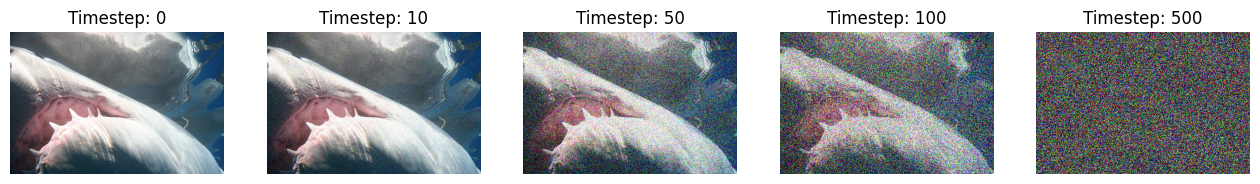

MSE values for n01484850_great_white_shark.JPEG: [0.00010002622002502903, 0.003281589364632964, 0.05452894791960716, 0.19391533732414246, 1.2838841676712036]


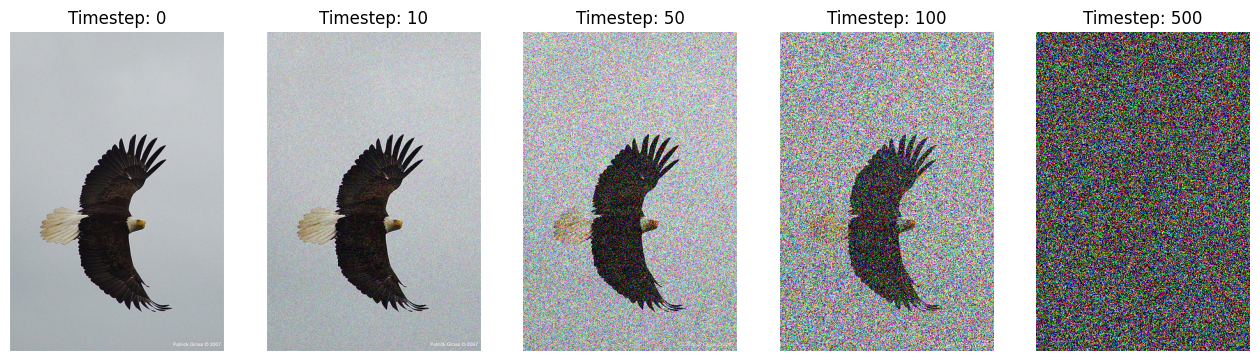

MSE values for n01614925_bald_eagle.JPEG: [0.00010007972014136612, 0.0032696654088795185, 0.05488758906722069, 0.1951339989900589, 1.402300238609314]


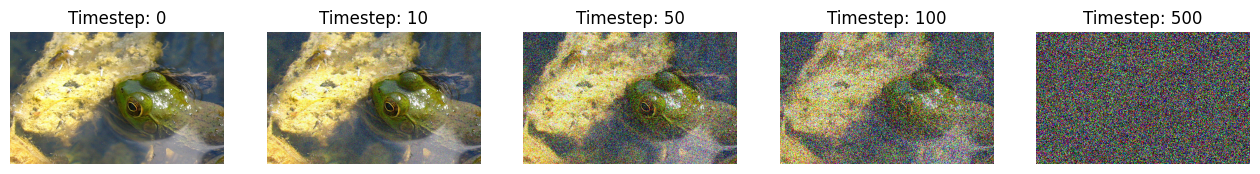

MSE values for n01641577_bullfrog.JPEG: [0.00010005303920479491, 0.003283898578956723, 0.05465179309248924, 0.1929120123386383, 1.2292670011520386]


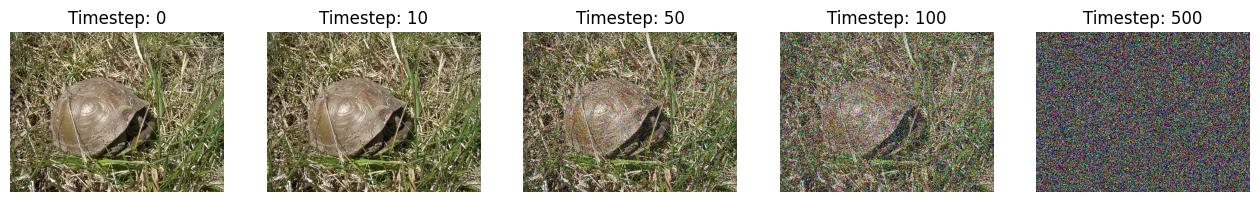

MSE values for n01669191_box_turtle.JPEG: [0.00010011790436692536, 0.0032708500511944294, 0.05436648428440094, 0.1933431178331375, 1.1859582662582397]


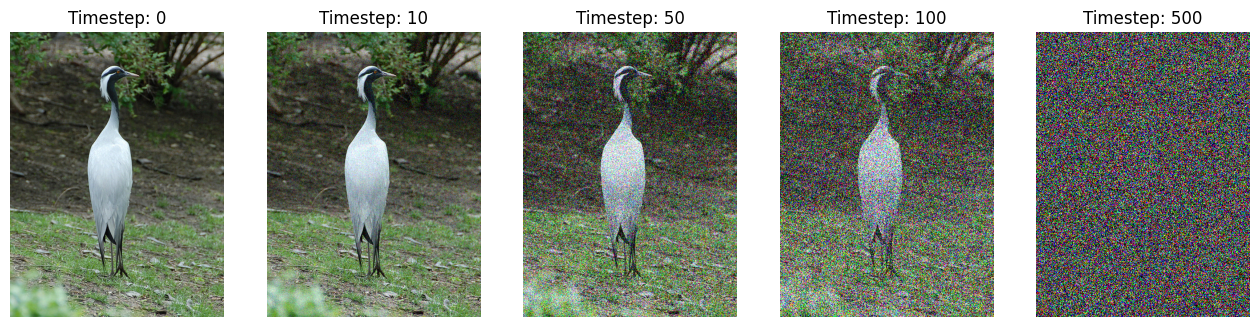

MSE values for n02012849_crane.JPEG: [9.996389417210594e-05, 0.0032949720043689013, 0.054510243237018585, 0.1926673948764801, 1.1372426748275757]


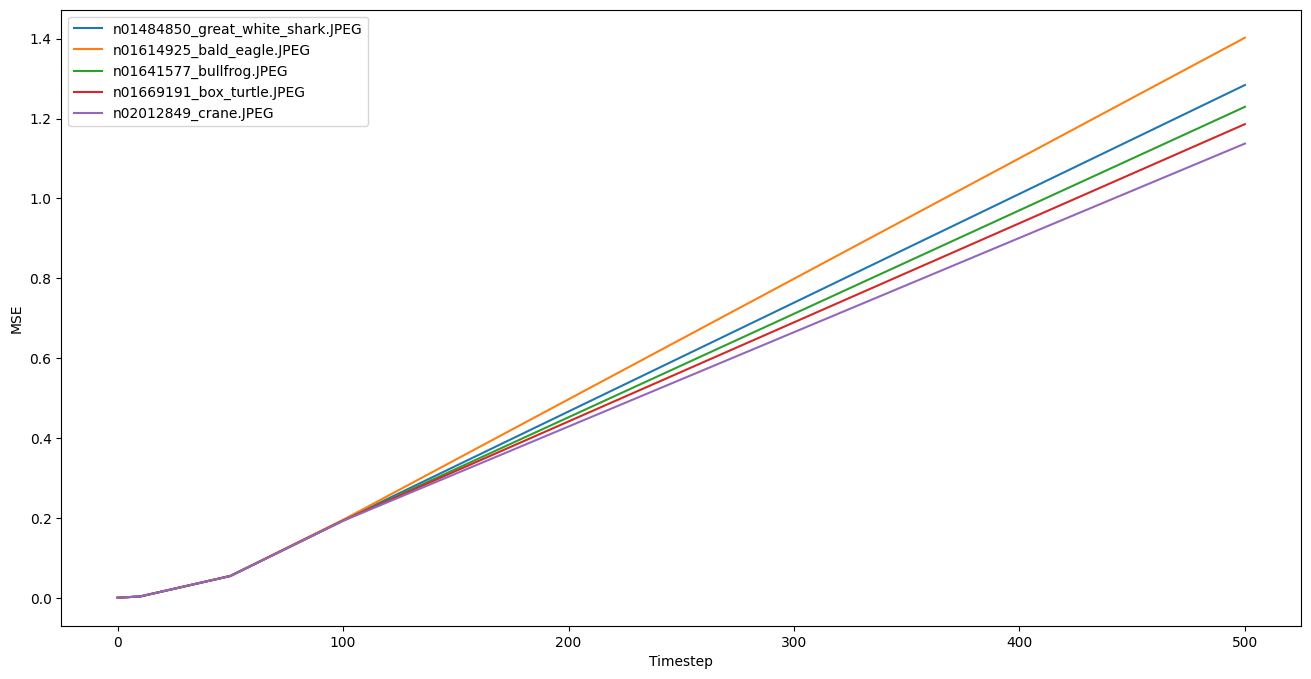

In [ ]:
class ForwardDiffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """ timesteps: num timesteps
            beta_start: starting value for noise schedule
            beta_end: ending value for noise schedule """

        self.timesteps = timesteps

        self.betas = torch.linspace(beta_start, beta_end, timesteps)

        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.]), self.alphas_cumprod[:-1]])

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

    def q_sample(self, x_0, t, noise=None):
        """ forward diffusion (sampling from q(x_t | x_0)

            x_0: initial data
            t: timestep to diffuse to
            noise: noise to add

            Returns: torch.Tensor: Noised data at timestep t """
        if noise is None:
            noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    def get_noisy_image(self, x_0, t):
        """ get noisy version of image at timestep t

            x_0: Original image
            t: Timestep

            Returns: Noisy image at timestep t """
        t_tensor = torch.tensor([t], device=x_0.device)
        return self.q_sample(x_0, t_tensor)

images = [
    "n01484850_great_white_shark.JPEG",
    "n01614925_bald_eagle.JPEG",
    "n01641577_bullfrog.JPEG",
    "n01669191_box_turtle.JPEG",
    "n02012849_crane.JPEG"
]
image_MSEs = []
for img in images:
    x_0 = torch.tensor(plt.imread(img)).type(torch.float32) / 255.0
    x_0 = x_0.unsqueeze(0).permute(0, 3, 1, 2)

    diffusion = ForwardDiffusion(timesteps=500 + 1)

    noisy_images = []
    timesteps = [0, 10, 50, 100, 500]

    mse_values = []

    for t in timesteps:
        noisy_image = diffusion.get_noisy_image(x_0, t)
        noisy_images.append(noisy_image)
        mse = torch.mean((x_0 - noisy_image) ** 2)
        mse_values.append(mse.item())

    plt.figure(figsize=(16, 8))
    for i, noisy_image in enumerate(noisy_images):
        plt.subplot(1, len(noisy_images), i + 1)
        plt.imshow(noisy_image.squeeze(0).permute(1, 2, 0))
        plt.title(f"Timestep: {timesteps[i]}")
        plt.axis('off')
    plt.show()

    image_MSEs.append(mse_values)
    print(f"MSE values for {img}: {mse_values}")

plt.figure(figsize=(16, 8))
for i, mse_values in enumerate(image_MSEs):
    plt.plot(timesteps, mse_values, label=images[i])

plt.xlabel('Timestep')
plt.ylabel('MSE')
plt.legend()
plt.show()



Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

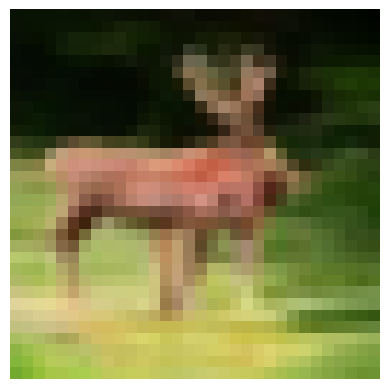

  0%|          | 0/50 [00:00<?, ?it/s]

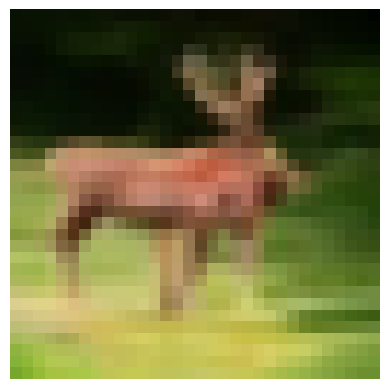

  0%|          | 0/10 [00:00<?, ?it/s]

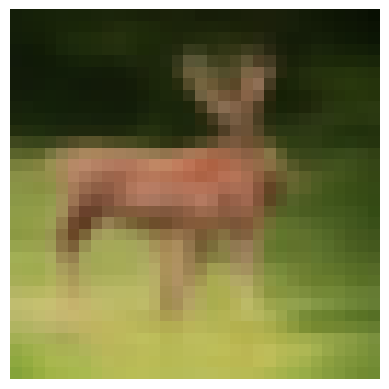

In [ ]:
from diffusers import DDIMPipeline

model_id = "google/ddpm-cifar10-32"

ddim = DDIMPipeline.from_pretrained(model_id)

for step in [100, 50, 10]:
    seed = 123
    np.random.seed(seed)
    torch.manual_seed(seed)

    image = ddim(num_inference_steps=step).images[0]

    plt.imshow(image)
    plt.axis('off')
    plt.show()